### imports

In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import time

import numpy as np
from numpy import where

from sklearn import tree
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from config import config

### Get the pandas dataframes from sql

In [2]:
def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # read connection parameters
        params = config()

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params)

        return conn

        
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)

In [3]:
conn = connect()

Connecting to the PostgreSQL database...


In [4]:
sql_query = """
select * 
from fact_table f, event ev, population p, education ed, country c, health h, month m, quality_of_life q
where f.event_key = ev.event_key and f.population_key = p.population_key and f.education_key = ed.education_key and 
f.country_key = c.country_key and f.health_key = h.health_key and f.month_key = m.month_key and f.quality_of_life_key = q.quality_of_life_key
"""

df = pd.DataFrame(pd.read_sql(sql_query, conn))

In [5]:
df.head()

,month_key,country_key,education_key,population_key,quality_of_life_key,health_key,event_key,quality_of_life,development_index,human_development_index,...,unemployment_rate_f,unemployment_rate_m,unemployment_rate_t,maternal_leave_benefits,access_to_electricity_total,access_to_electricity_urban,access_to_electricity_rural,part_time_employment_t,part_time_employment_f,part_time_employment_m
0,4,0,0,0,0,0,26,90,1,1,...,6.466,7.017,6.76,NaN,100.0,100.0,100.0,38.200001,48.849998,28.83
1,5,0,0,0,0,0,22,90,1,1,...,6.466,7.017,6.76,NaN,100.0,100.0,100.0,38.200001,48.849998,28.83
2,6,0,0,0,0,0,23,90,1,1,...,6.466,7.017,6.76,NaN,100.0,100.0,100.0,38.200001,48.849998,28.83
3,7,0,0,0,0,0,24,90,1,1,...,6.466,7.017,6.76,NaN,100.0,100.0,100.0,38.200001,48.849998,28.83
4,8,0,0,0,0,0,21,90,1,1,...,6.466,7.017,6.76,NaN,100.0,100.0,100.0,38.200001,48.849998,28.83


## Part A1
### Getting a "feel" for the data

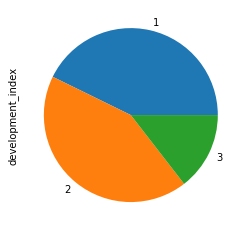

In [6]:
# make a pie chart to see the distribution of the development index
plt1 = df['development_index'].value_counts().plot(kind='pie')


C:\Users\Nicholas\AppData\Local\Temp/ipykernel_13192/1136854827.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt2.get_figure().show()


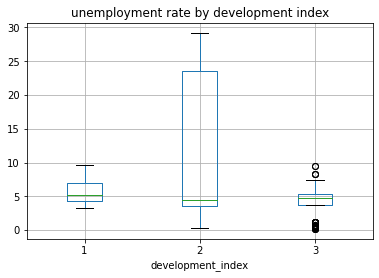

In [7]:
# make a boxplot comparing the development index and the life expectancy
plt2 = df.boxplot(column='unemployment_rate_t', by='development_index')
plt2.set_title('unemployment rate by development index')
plt2.get_figure().suptitle('')
plt2.get_figure().show()


C:\Users\Nicholas\AppData\Local\Temp/ipykernel_13192/743161887.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt3.get_figure().show()


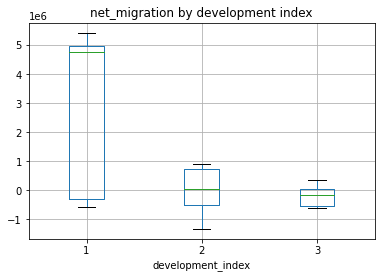

In [8]:
# make a boxplot comparing the development index and the net migration
plt3 = df.boxplot(column='net_migration', by='development_index')
plt3.set_title('net_migration by development index')
plt3.get_figure().suptitle('')
plt3.get_figure().show()

C:\Users\Nicholas\AppData\Local\Temp/ipykernel_13192/754714647.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt4.get_figure().show()


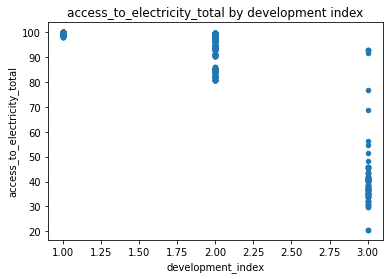

In [9]:
# make a scatter plot to compare the development index and access to drinking water
plt4 = df.plot(kind='scatter', x='development_index', y='access_to_electricity_total')
plt4.set_title('access_to_electricity_total by development index')
plt4.get_figure().suptitle('')
plt4.get_figure().show()

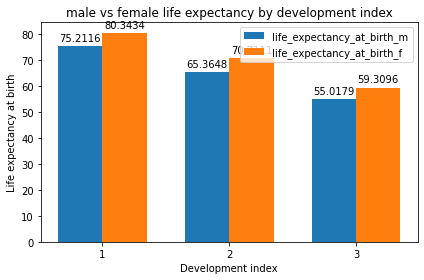

In [10]:
# graph the differences in male and female life expectencies with respect to the development index
df.groupby('development_index')['life_expectancy_at_birth_t'].mean().to_list()

labels = ['1','2','3']
life_expectancy_at_birth_m_means = df.groupby('development_index')['life_expectancy_at_birth_m'].mean().to_list()
life_expectancy_at_birth_f_means = df.groupby('development_index')['life_expectancy_at_birth_f'].mean().to_list()

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, life_expectancy_at_birth_m_means, width, label='life_expectancy_at_birth_m')
rects2 = ax.bar(x + width/2, life_expectancy_at_birth_f_means, width, label='life_expectancy_at_birth_f')

ax.set_ylabel('Life expectancy at birth')
ax.set_xlabel('Development index')
ax.set_title('male vs female life expectancy by development index')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()


## Part A2

### Feature selection:

The features we chose are:
life_expectancy_at_birth_t\
life_expectancy_at_birth_m\
life_expectancy_at_birth_f\
net_migration\
rural_population\
urban_population\
number_of_infant_deaths\
number_of_stillbirths\
unemployment_rate_t\
unemployment_rate_m\
unemployment_rate_f\
part_time_employment_t\
access_to_electricity_total\
access_to_drinking_water\
access_to_sanitation\
immunization_hepb3\
immunization_dpt\
immunization_measles\
immunization_pol3\
domestic_general_government_health_expenditure\
population_growth_annual\
pop_compulsory_school_age_total\
disaster_type\
disaster_subgroup

In [11]:
df_reduced = df[['life_expectancy_at_birth_t',
'life_expectancy_at_birth_m',
'life_expectancy_at_birth_f',
'net_migration',
'rural_population',
'urban_population',
'number_of_infant_deaths',
'number_of_stillbirths',
'unemployment_rate_t',
'unemployment_rate_m',
'unemployment_rate_f',
'part_time_employment_t',
'access_to_electricity_total',
'access_to_drinking_water',
'access_to_sanitation',
'immunization_hepb3',
'immunization_dpt',
'immunization_measles',
'immunization_pol3',
'domestic_general_government_health_expenditure',
'population_grown_annual',
'pop_compuslory_school_age_total',
'disaster_type',
'disaster_subgroup']]

In [12]:
df_reduced.head()

,life_expectancy_at_birth_t,life_expectancy_at_birth_m,life_expectancy_at_birth_f,net_migration,rural_population,urban_population,number_of_infant_deaths,number_of_stillbirths,unemployment_rate_t,unemployment_rate_m,...,access_to_sanitation,immunization_hepb3,immunization_dpt,immunization_measles,immunization_pol3,domestic_general_government_health_expenditure,population_grown_annual,pop_compuslory_school_age_total,disaster_type,disaster_subgroup
0,80.192683,77.9,82.6,1326431,19.878,80.122,1800.0,1037.0,6.76,7.017,...,99.805195,14.0,93.0,94.0,93.0,6.599058,0.944467,4092573.0,Miscellaneous accident,Technological
1,80.192683,77.9,82.6,1326431,19.878,80.122,1800.0,1037.0,6.76,7.017,...,99.805195,14.0,93.0,94.0,93.0,6.599058,0.944467,4092573.0,Flood,Hydrological
2,80.192683,77.9,82.6,1326431,19.878,80.122,1800.0,1037.0,6.76,7.017,...,99.805195,14.0,93.0,94.0,93.0,6.599058,0.944467,4092573.0,Wildfire,Climatological
3,80.192683,77.9,82.6,1326431,19.878,80.122,1800.0,1037.0,6.76,7.017,...,99.805195,14.0,93.0,94.0,93.0,6.599058,0.944467,4092573.0,Wildfire,Climatological
4,80.192683,77.9,82.6,1326431,19.878,80.122,1800.0,1037.0,6.76,7.017,...,99.805195,14.0,93.0,94.0,93.0,6.599058,0.944467,4092573.0,Flood,Hydrological


### Handling categorical attributes through one-hot encoding

In [13]:
df_ohe = pd.get_dummies(df_reduced)

df_ohe.head()

,life_expectancy_at_birth_t,life_expectancy_at_birth_m,life_expectancy_at_birth_f,net_migration,rural_population,urban_population,number_of_infant_deaths,number_of_stillbirths,unemployment_rate_t,unemployment_rate_m,...,disaster_type_Storm,disaster_type_Transport accident,disaster_type_Volcanic activity,disaster_type_Wildfire,disaster_subgroup_Biological,disaster_subgroup_Climatological,disaster_subgroup_Geophysical,disaster_subgroup_Hydrological,disaster_subgroup_Meteorological,disaster_subgroup_Technological
0,80.192683,77.9,82.6,1326431,19.878,80.122,1800.0,1037.0,6.76,7.017,...,0,0,0,0,0,0,0,0,0,1
1,80.192683,77.9,82.6,1326431,19.878,80.122,1800.0,1037.0,6.76,7.017,...,0,0,0,0,0,0,0,1,0,0
2,80.192683,77.9,82.6,1326431,19.878,80.122,1800.0,1037.0,6.76,7.017,...,0,0,0,1,0,1,0,0,0,0
3,80.192683,77.9,82.6,1326431,19.878,80.122,1800.0,1037.0,6.76,7.017,...,0,0,0,1,0,1,0,0,0,0
4,80.192683,77.9,82.6,1326431,19.878,80.122,1800.0,1037.0,6.76,7.017,...,0,0,0,0,0,0,0,1,0,0


### Handling of missing values
Most of this was handled in deliverable 2 but we still have some null values so we will impute them with pandas

In [14]:

for col in df_ohe.columns[df_ohe.isna().any()].tolist():
    df_ohe[col].fillna(df_ohe[col].mean(), inplace=True)
    


### Normalization of numeric attributes to ensure all attributes are of equal importance during learning

In [15]:
scaler = preprocessing.MinMaxScaler()
names = df_ohe.columns.to_list()
df_ohe[names] = scaler.fit_transform(df_ohe[names])

df_ohe.head()


,life_expectancy_at_birth_t,life_expectancy_at_birth_m,life_expectancy_at_birth_f,net_migration,rural_population,urban_population,number_of_infant_deaths,number_of_stillbirths,unemployment_rate_t,unemployment_rate_m,...,disaster_type_Storm,disaster_type_Transport accident,disaster_type_Volcanic activity,disaster_type_Wildfire,disaster_subgroup_Biological,disaster_subgroup_Climatological,disaster_subgroup_Geophysical,disaster_subgroup_Hydrological,disaster_subgroup_Meteorological,disaster_subgroup_Technological
0,0.952172,0.945351,0.959223,0.393366,0.040038,0.959962,0.000665,0.0,0.227568,0.249774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.952172,0.945351,0.959223,0.393366,0.040038,0.959962,0.000665,0.0,0.227568,0.249774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.952172,0.945351,0.959223,0.393366,0.040038,0.959962,0.000665,0.0,0.227568,0.249774,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.952172,0.945351,0.959223,0.393366,0.040038,0.959962,0.000665,0.0,0.227568,0.249774,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.952172,0.945351,0.959223,0.393366,0.040038,0.959962,0.000665,0.0,0.227568,0.249774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Part B. Classification

The label of our choice is Development-Index

In [16]:
y = df['development_index'].to_numpy()
x = df_ohe.to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.34, random_state=42)

### Decision Tree

[Text(0.6, 0.8333333333333334, 'X[5] <= 0.829\ngini = 0.62\nsamples = 504\nvalue = [215, 210, 79]'),
 Text(0.4, 0.5, 'X[13] <= 0.546\ngini = 0.397\nsamples = 289\nvalue = [0, 210, 79]'),
 Text(0.2, 0.16666666666666666, 'gini = 0.0\nsamples = 79\nvalue = [0, 0, 79]'),
 Text(0.6, 0.16666666666666666, 'gini = 0.0\nsamples = 210\nvalue = [0, 210, 0]'),
 Text(0.8, 0.5, 'gini = 0.0\nsamples = 215\nvalue = [215, 0, 0]')]

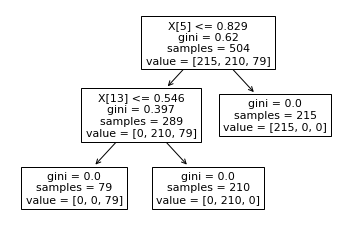

In [17]:
start_dt = time.time()
dt_clf = tree.DecisionTreeClassifier()
dt_clf = dt_clf.fit(x_train, y_train)
end_dt = time.time()
tree.plot_tree(dt_clf)

In [18]:
print(dt_clf.score(x_test, y_test))
confusion_matrix(y_test, dt_clf.predict(x_test))

1.0


array([[112,   0,   0],
       [  0, 117,   0],
       [  0,   0,  32]], dtype=int64)

### Gradient Boosting

In [19]:
start_gb = time.time()
gb_clf = GradientBoostingClassifier()
gb_clf = gb_clf.fit(x_train, y_train)
end_gb = time.time()


In [20]:
print(gb_clf.score(x_test, y_test))
confusion_matrix(y_test, gb_clf.predict(x_test))

1.0


array([[112,   0,   0],
       [  0, 117,   0],
       [  0,   0,  32]], dtype=int64)

### Random Forest

In [21]:
start_rf = time.time()
rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(x_train, y_train)
end_rf = time.time()

In [22]:
print(rf_clf.score(x_test, y_test))
confusion_matrix(y_test, rf_clf.predict(x_test))

1.0


array([[112,   0,   0],
       [  0, 117,   0],
       [  0,   0,  32]], dtype=int64)

### Calculate the accuracy, precision, recall, and time to construct each model

In [24]:
# calculate the accuracy, precision, and recall of the decision tree model and get the time it took to generate
dt_accuracy = dt_clf.score(x_test, y_test)
dt_precision = precision_score(y_test, dt_clf.predict(x_test), average='micro')
dt_recall = recall_score(y_test, dt_clf.predict(x_test), average='micro')
dt_time = end_dt - start_dt

# calculate the accuracy, precision, and recall of the gradient boosting model and get the time it took to generate
gb_accuracy = gb_clf.score(x_test, y_test)
gb_precision = precision_score(y_test, gb_clf.predict(x_test), average='micro')
gb_recall = recall_score(y_test, gb_clf.predict(x_test), average='micro')
gb_time = end_gb - start_gb

# calculate the accuracy, precision, and recall of the random forest model and get the time it took to generate
rf_accuracy = rf_clf.score(x_test, y_test)
rf_precision = precision_score(y_test, rf_clf.predict(x_test), average='micro')
rf_recall = recall_score(y_test, rf_clf.predict(x_test), average='micro')
rf_time = end_rf - start_rf


# create a dataframe to store the results
results = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'time (seconds)'])
results.loc[0] = ['Decision Tree', dt_accuracy, dt_precision, dt_recall, dt_time]
results.loc[1] = ['Gradient Boosting', gb_accuracy, gb_precision, gb_recall, gb_time]
results.loc[2] = ['Random Forest', rf_accuracy, rf_precision, rf_recall, rf_time]

results.head()


,model,accuracy,precision,recall,time (seconds)
0,Decision Tree,1.0,1.0,1.0,0.001000
1,Gradient Boosting,1.0,1.0,1.0,0.253717
2,Random Forest,1.0,1.0,1.0,0.068058


# Part C. Detecting Outliers

In [29]:
svm_clf = svm.OneClassSVM(gamma='auto').fit(x)
pred = svm_clf.predict(x)

outlier_index = where(pred == -1)
outlier_values = df_ohe.iloc[outlier_index]

outlier_values

,life_expectancy_at_birth_t,life_expectancy_at_birth_m,life_expectancy_at_birth_f,net_migration,rural_population,urban_population,number_of_infant_deaths,number_of_stillbirths,unemployment_rate_t,unemployment_rate_m,...,disaster_type_Storm,disaster_type_Transport accident,disaster_type_Volcanic activity,disaster_type_Wildfire,disaster_subgroup_Biological,disaster_subgroup_Climatological,disaster_subgroup_Geophysical,disaster_subgroup_Hydrological,disaster_subgroup_Meteorological,disaster_subgroup_Technological
0,0.952172,0.945351,0.959223,0.393366,0.040038,0.959962,0.000665,0.000000,0.227568,0.249774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.952172,0.945351,0.959223,0.393366,0.040038,0.959962,0.000665,0.000000,0.227568,0.249774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.952172,0.945351,0.959223,0.393366,0.040038,0.959962,0.000665,0.000000,0.227568,0.249774,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.952172,0.945351,0.959223,0.393366,0.040038,0.959962,0.000665,0.000000,0.227568,0.249774,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.952172,0.945351,0.959223,0.393366,0.040038,0.959962,0.000665,0.000000,0.227568,0.249774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,0.452770,0.456242,0.439829,0.110818,0.794251,0.205749,0.100586,0.095840,0.159645,0.153395,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
761,0.462639,0.466547,0.449462,0.110818,0.794692,0.205308,0.095522,0.093313,0.160023,0.153649,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
762,0.462639,0.466547,0.449462,0.110818,0.794692,0.205308,0.095522,0.093313,0.160023,0.153649,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
763,0.470241,0.474276,0.457133,0.110818,0.794676,0.205324,0.091942,0.092461,0.161296,0.154842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
